# Projeto de Previsão de Acidente Vascular Cerebral (AVC) com Python

Este notebook realiza a análise completa para a construção e avaliação de um modelo preditivo de AVC, seguindo a rubrica de Machine Learning para a área da saúde.

# Tarefa Um: Importação de dados e pré-processamento de dados

## Carregar dados e instalar pacotes

In [5]:
# Importação das bibliotecas essenciais para Ciência de Dados em Python

# Pandas: A biblioteca principal para carregar, manipular e limpar dados (nosso 'tidyverse' do Python)
import pandas as pd 
# NumPy: Usado para operações numéricas e arrays
import numpy as np 
# Matplotlib/Seaborn: Usados para visualização de dados (criação de gráficos). Seaborn é ótimo para estatística.
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn: É a biblioteca padrão para Machine Learning em Python
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define o caminho do arquivo
file_path = '../data/healthcare-dataset-stroke-data.csv'

# Lê o arquivo CSV para um DataFrame do Pandas (df)
df = pd.read_csv(file_path)

# Mostra as primeiras 5 linhas para verificar se o carregamento funcionou
print("--- Primeiras 5 linhas do Dataset ---")
display(df.head())

--- Primeiras 5 linhas do Dataset ---


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Descreva e explore os dados

In [9]:
# Remove a coluna 'id' imediatamente se ela existir, embora tenhamos confirmado que ela não existe.
# O bloco 'try/except' garante que o código não quebre se a coluna não for encontrada (boa prática!)
try:
    df = df.drop('id', axis=1)
except KeyError:
    print("A coluna 'id' não foi encontrada, seguindo com o DataFrame original.")

# --- EXPLORAÇÃO INICIAL: Estrutura e Tipos de Dados ---
print("--- Estrutura e Tipos de Dados ---")
# .info() fornece um resumo: número de linhas, colunas e, o mais importante,
# o tipo de dado de cada coluna (float, int, object) e a contagem de valores não-nulos.
df.info()

# --- VERIFICAÇÃO DE VALORES AUSENTES (NA) ---
# O .isnull() verifica onde há NA (retorna True/False) e .sum() soma quantos há por coluna
print("\n--- Contagem de Valores Ausentes (NA) ---")
print(df.isnull().sum())

A coluna 'id' não foi encontrada, seguindo com o DataFrame original.
--- Estrutura e Tipos de Dados ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB

--- Contagem de Valores Ausentes (NA) ---
gender                 0
age                    0
hyperten

## Limpeza e Imputação de Dados

Esta seção aborda o tratamento dos valores ausentes (NaN) encontrados na coluna 'bmi' e a limpeza final dos dados antes da Análise Exploratória (EDA).

In [10]:
# --- 1. TRATAMENTO DO BMI (IMPUTAÇÃO) ---

# Raciocínio: Usamos a Mediana pois é mais robusta (menos afetada por outliers) que a Média.
median_bmi = df['bmi'].median(skipna=True)

print(f"Mediana de BMI a ser usada na imputação: {median_bmi:.2f}")

# Preenche (imputa) os valores ausentes (NaN) na coluna 'bmi' com a mediana calculada.
df['bmi'] = df['bmi'].fillna(median_bmi)

# --- 2. TRATAMENTO DE VARIÁVEIS CATEÓRICAS RARA ---

# Na coluna 'gender', o valor 'Other' é extremamente raro (apenas 1 caso) e pode causar problemas
# de modelo. Vamos removê-lo.
df = df[df['gender'] != 'Other']

# --- 3. RE-VERIFICAÇÃO ---
# Confirma se todos os NAs foram tratados e se a linha 'Other' foi removida.

print("\n--- Contagem de Valores Ausentes (NA) após Imputação ---")
print(df.isnull().sum())
print("\nDimensões do Dataset após limpeza:")
print(df.shape)

Mediana de BMI a ser usada na imputação: 28.10

--- Contagem de Valores Ausentes (NA) após Imputação ---
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Dimensões do Dataset após limpeza:
(5109, 11)


## Análise Exploratória de Dados (EDA): Visualizações

A EDA visa identificar as características clínicas e/ou do paciente mais importantes na previsão de AVC, usando a variável alvo 'stroke'.

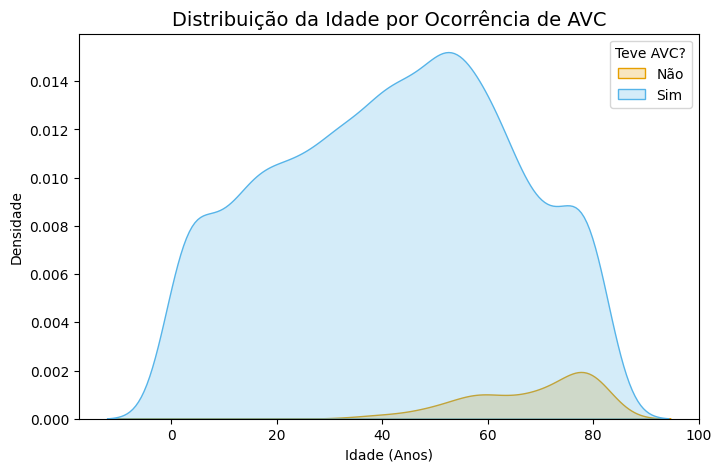

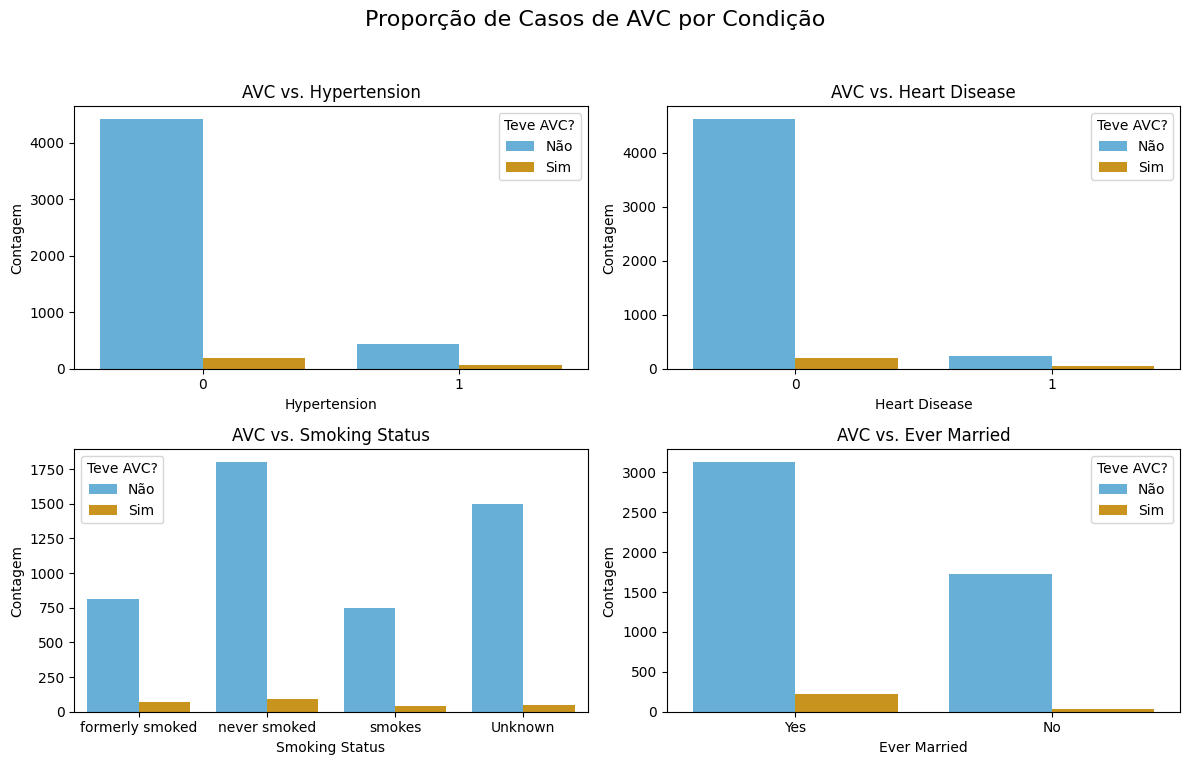

In [11]:
# --- VISUALIZAÇÃO 1: Relação entre Idade e AVC (stroke) ---

plt.figure(figsize=(8, 5))
# kde=True cria o gráfico de densidade para comparar as distribuições
sns.kdeplot(data=df, x='age', hue='stroke', fill=True, palette={0: '#56B4E9', 1: '#E69F00'})
plt.title('Distribuição da Idade por Ocorrência de AVC', fontsize=14)
plt.xlabel('Idade (Anos)')
plt.ylabel('Densidade')
plt.legend(title='Teve AVC?', labels=['Não', 'Sim'])
plt.show()

# --- VISUALIZAÇÃO 2: Risco de AVC por Fatores Categóricos ---

# Cria gráficos de barras para comparar as proporções de AVC em variáveis chave
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Proporção de Casos de AVC por Condição', fontsize=16)

# Variáveis para plotar (hypertension e heart_disease são binárias, smoking_status e ever_married são categóricas)
categorical_cols = ['hypertension', 'heart_disease', 'smoking_status', 'ever_married']

for i, col in enumerate(categorical_cols):
    row = i // 2
    col_ = i % 2
    
    # Cria a contagem de casos de AVC (1) e Não-AVC (0)
    sns.countplot(data=df, x=col, hue='stroke', palette={0: '#56B4E9', 1: '#E69F00'}, ax=axes[row, col_])
    axes[row, col_].set_title(f'AVC vs. {col.replace("_", " ").title()}')
    axes[row, col_].legend(title='Teve AVC?', labels=['Não', 'Sim'])
    axes[row, col_].set_xlabel(col.replace("_", " ").title())
    axes[row, col_].set_ylabel('Contagem')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição
plt.show()

# Task Two: Build prediction models

## 4. Particionamento e Preparação dos Dados


## 5. Treinamento dos Modelos

# Task Three: Evaluate and select prediction models

# Task Four: Deploy the prediction model

# Task Five: Findings and Conclusions